# Notebook II:  Transfer Learning Modeling and Inference - "Fruits" Image Dataset
## Preparing and loading the required libraries

In [1]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import pandas as pd
import os
import PIL
import tensorflow as tf
import platform
import glob
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from tensorflow import keras
import tensorflow_hub as hub
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from tensorflow.python.client import device_lib
from tensorflow.keras.utils import to_categorical
import keras_tuner as kt
%load_ext tensorboard

import datetime
import pathlib
import shutil

In [2]:
print("Python version:", platform.python_version())
print("TF version:", tf.__version__)

Python version: 3.9.12
TF version: 2.6.0


In [3]:
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 8431477222692466103,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 1221733034
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 16695516492208658869
 physical_device_desc: "device: 0, name: NVIDIA RTX A3000 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6"]

## Loading and Preprocessing data

In [4]:
batch_size = 32
img_height = 100  
img_width = 100   
input_shape = (img_height, img_width, 1)

In [5]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  "../export/train",
  validation_split=0.1,
  subset="training",
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4754 files belonging to 5 classes.
Using 4279 files for training.


In [6]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  "../export/train",
  validation_split=0.1,
  subset="validation",
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 4754 files belonging to 5 classes.
Using 475 files for validation.


In [7]:
data_dir_test = pathlib.Path("../export/test")

test_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_test,
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 530 files belonging to 5 classes.


In [8]:
class_names = np.array(train_ds.class_names)
print(class_names)

['Apple' 'Apricot' 'Limes' 'Orange' 'Pear']


In [9]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 100, 100, 3)
(32,)


## Configuring the data sets for better performance in training

In [10]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Load model from Tensorflow Hub

In [11]:
mobilenet_v2 = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
efficientnet_v2_b0 = "https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_ft1k_b0/feature_vector/2"

feature_extractor_model = efficientnet_v2_b0

In [12]:
feature_extractor_layer = hub.KerasLayer(
    feature_extractor_model,
    input_shape=(224, 224, 3),
    trainable=False)

## Extend and compile the pre-trained model for our application

In [13]:
num_classes = len(class_names)

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  feature_extractor_layer,
  tf.keras.layers.Dense(num_classes)
])


In [14]:
root_dir = ".."
shutil.rmtree(os.path.join(root_dir, 'tensorboard'), ignore_errors=True, onerror=None)
os.makedirs(os.path.join(root_dir, 'tensorboard'))

In [15]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

log_dir = "../tensorboard/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + "_tl"
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir,
    histogram_freq=1) # Enable histogram computation for every epoch.

## Start training with the specified parameters

In [16]:
epochs = 10

history = model.fit(train_ds,
                    validation_data=val_ds,
                    epochs=epochs,
                    callbacks=tensorboard_callback)

Epoch 1/10
134/134 [==============================] - 26s 106ms/step - loss: 0.3106 - acc: 0.9126 - val_loss: 0.0613 - val_acc: 1.0000
Epoch 2/10
134/134 [==============================] - 5s 35ms/step - loss: 0.0378 - acc: 0.9979 - val_loss: 0.0274 - val_acc: 1.0000
Epoch 3/10
134/134 [==============================] - 5s 38ms/step - loss: 0.0192 - acc: 0.9993 - val_loss: 0.0162 - val_acc: 1.0000
Epoch 4/10
134/134 [==============================] - 5s 37ms/step - loss: 0.0118 - acc: 0.9998 - val_loss: 0.0108 - val_acc: 1.0000
Epoch 5/10
134/134 [==============================] - 5s 39ms/step - loss: 0.0081 - acc: 1.0000 - val_loss: 0.0078 - val_acc: 1.0000
Epoch 6/10
134/134 [==============================] - 5s 39ms/step - loss: 0.0060 - acc: 1.0000 - val_loss: 0.0060 - val_acc: 1.0000
Epoch 7/10
134/134 [==============================] - 5s 37ms/step - loss: 0.0046 - acc: 1.0000 - val_loss: 0.0047 - val_acc: 1.0000
Epoch 8/10
134/134 [==============================] - 5s 39ms/step 

## Monitor training results with TensorBoard

In [17]:
%tensorboard --logdir "../tensorboard"

Reusing TensorBoard on port 6006 (pid 17824), started 23:39:29 ago. (Use '!kill 17824' to kill it.)

## Predictions with new, unseen data

In [18]:
for image_batch, labels_batch in test_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 100, 100, 3)
(32,)


In [19]:
predicted_batch = model.predict(image_batch)
predicted_id = tf.math.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

In [20]:
cm = confusion_matrix(labels_batch, predicted_id)

In [21]:
def show_confusion_matrix(cm, labels):
  plt.figure(figsize=(10, 8))
  sns.heatmap(cm, xticklabels=labels, yticklabels=labels, 
              annot=True, fmt='g')
  plt.xlabel('Prediction')
  plt.ylabel('Label')
  plt.show()

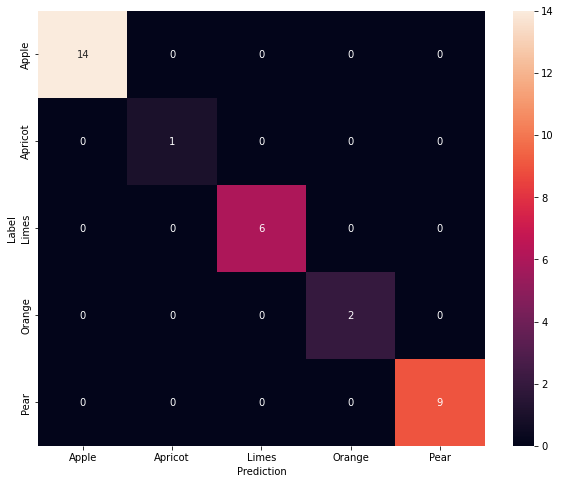

In [22]:
show_confusion_matrix(cm, class_names)

In [23]:
print(classification_report(labels_batch, predicted_id, target_names=class_names))

              precision    recall  f1-score   support

       Apple       1.00      1.00      1.00        14
     Apricot       1.00      1.00      1.00         1
       Limes       1.00      1.00      1.00         6
      Orange       1.00      1.00      1.00         2
        Pear       1.00      1.00      1.00         9

    accuracy                           1.00        32
   macro avg       1.00      1.00      1.00        32
weighted avg       1.00      1.00      1.00        32



## Illustration of the predictions using a batch of images

In [24]:
def plot_inferences(image_batch, predicted_labels, rows, cols):
  count = 0

  fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(12,12))

  for i in range(rows):
    for j in range(cols):
      img = image_batch[count]/255
      axes[i, j].imshow(img)
      axes[i, j].set_title(f"{predicted_labels[count].title()}, {img.shape}")
      count+=1
  fig.suptitle("Prediction Fruits", fontsize=18)
  plt.show()

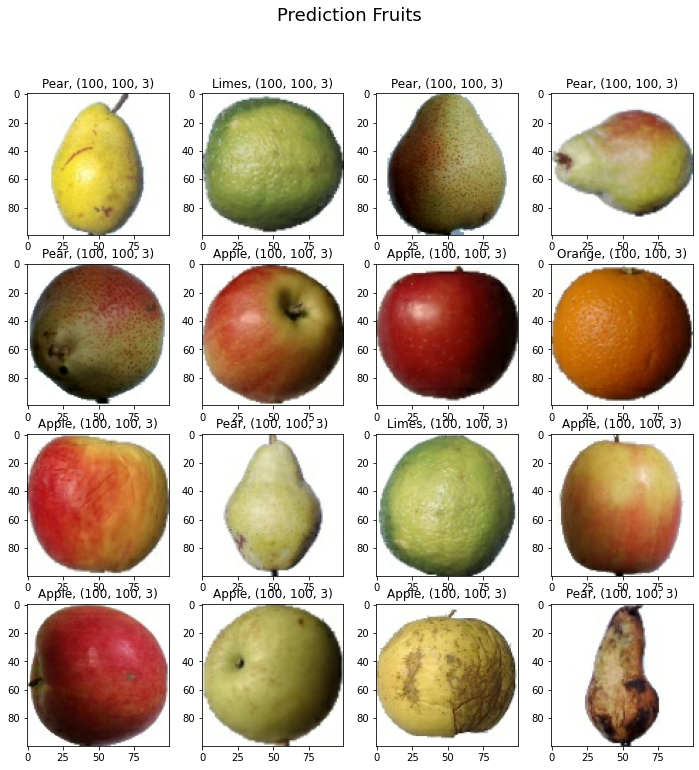

In [25]:
plot_inferences(image_batch, predicted_label_batch, 4, 4)

## Testing predictions for self-created photos

In [26]:
batch_size = 32
img_height = 100  
img_width = 100   
input_shape = (img_height, img_width, 1)

In [27]:
data_dir_test_photos = pathlib.Path("../self-photographed_images_fruits")

test_photos_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir_test_photos,
  seed=42,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 34 files belonging to 5 classes.


In [28]:
class_names_photos = np.array(test_photos_ds.class_names)
print(class_names)

['Apple' 'Apricot' 'Limes' 'Orange' 'Pear']


In [29]:
for image_batch_photos, labels_batch_photos in test_photos_ds:
  print(image_batch_photos.shape)
  print(labels_batch_photos.shape)
  break

(32, 100, 100, 3)
(32,)


In [30]:
predicted_batch_photos = model.predict(image_batch_photos)
predicted_id = tf.math.argmax(predicted_batch_photos, axis=-1)
predicted_label_batch = class_names[predicted_id]

In [31]:
cm = confusion_matrix(labels_batch, predicted_id)

In [32]:
def show_confusion_matrix(cm, labels):
  plt.figure(figsize=(10, 8))
  sns.heatmap(cm, xticklabels=labels, yticklabels=labels, 
              annot=True, fmt='g')
  plt.xlabel('Prediction')
  plt.ylabel('Label')
  plt.show()

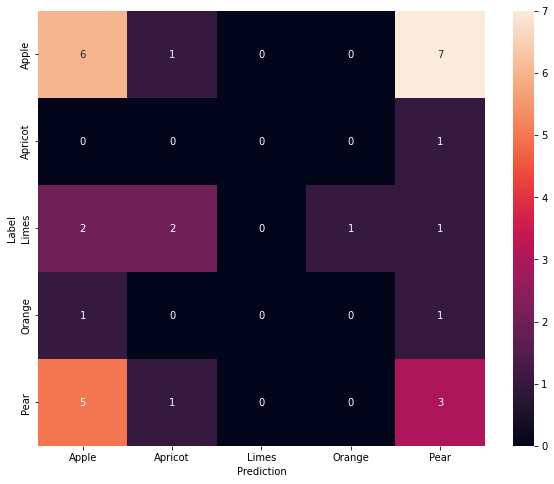

In [33]:
show_confusion_matrix(cm, class_names_photos)

In [34]:
print(classification_report(labels_batch, predicted_id, target_names=class_names))

              precision    recall  f1-score   support

       Apple       0.43      0.43      0.43        14
     Apricot       0.00      0.00      0.00         1
       Limes       0.00      0.00      0.00         6
      Orange       0.00      0.00      0.00         2
        Pear       0.23      0.33      0.27         9

    accuracy                           0.28        32
   macro avg       0.13      0.15      0.14        32
weighted avg       0.25      0.28      0.26        32



In [35]:
def plot_inferences(image_batch_photos, predicted_labels, rows, cols):
  count = 0

  fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(12,12))

  for i in range(rows):
    for j in range(cols):
      img = image_batch_photos[count]/255
      axes[i, j].imshow(img)
      axes[i, j].set_title(f"{predicted_labels[count].title()}, {img.shape}")
      count+=1
  fig.suptitle("Prediction Fruits - Self Photographed Images", fontsize=18)
  plt.show()

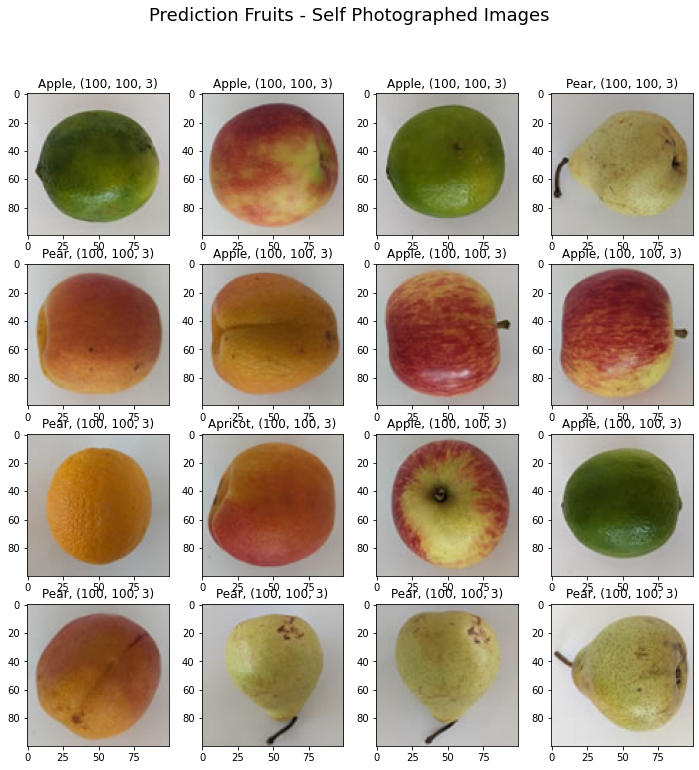

In [36]:
plot_inferences(image_batch_photos, predicted_label_batch, 4, 4)